# PaperCompanion3 - Deterministic Approximation in Policy Space
Notebook to generate figure 3 of the paper, depicting the approximated 4D deterministic learning trajectories in policy space. The time evolution is reflected in the color gradient of the trajectories.

In [1]:
# import general libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy.optimize import fsolve
import os
# import own functions
from agent_game_sim import reward_matrix_for_two_player_PD
from agent_game_sim import get_individual_matrices
from agent_game_sim import generate_q_values
from agent_game_sim import calculate_fixed_point_policy
from agent_game_sim import calculate_target_Q_values
from agent_game_sim import calculate_eigenvalues_and_eigenvectors

In [2]:
class DeterministicAgent():
    def __init__(self, Q_values_initial, learning_rate, discount_factor, temperature):
        self.Q_values_initial = Q_values_initial
        self.Q_values = Q_values_initial
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.temperature = temperature
        self.Q_values_history = []         # history of Q-values
        self.prob_vector_history = []        # history of probabilities

    def get_prob_vector(self):
        return np.exp(self.Q_values / self.temperature) / np.sum(np.exp(self.Q_values / self.temperature))
    
    def update_history(self):
        self.Q_values_history.append(self.Q_values)
        self.prob_vector_history.append(self.get_prob_vector())

    def reset(self):
        self.Q_values = self.Q_values_initial

def deterministic_QL_step(agents, reward_matrices):
    '''Deterministic Q-learning step for a symmetric 2x2 repeated normal-form game for two agents'''
    # update history
    for agent in agents:
        agent.update_history()

    # get the probability vector of the agents
    agent_1, agent_2 = agents
    prob_vector_agent_1 = agent_1.get_prob_vector()
    prob_vector_agent_2 = agent_2.get_prob_vector()

    # get the reward matrices
    reward_matrix_A, reward_matrix_B = reward_matrices
    
    # update the Q-values via deterministic equation
    Q_vector_new_1 = agent_1.Q_values + agent_1.learning_rate * prob_vector_agent_1 * (reward_matrix_A @ prob_vector_agent_2 + agent_1.discount_factor * np.max(agent_1.Q_values) - agent_1.Q_values)
    Q_vector_new_2 = agent_2.Q_values + agent_2.learning_rate * prob_vector_agent_2 * (prob_vector_agent_1 @ reward_matrix_B + agent_2.discount_factor * np.max(agent_2.Q_values) - agent_2.Q_values)

    # update the Q-values
    agent_1.Q_values = Q_vector_new_1
    agent_2.Q_values = Q_vector_new_2

Run finished for initial probability pair (0.1, 0.9) Progress: 1/11
Run finished for initial probability pair (0.5, 0.9) Progress: 2/11
Run finished for initial probability pair (0.7, 0.9) Progress: 3/11
Run finished for initial probability pair (0.9, 0.9) Progress: 4/11
Run finished for initial probability pair (0.9, 0.7) Progress: 5/11
Run finished for initial probability pair (0.1, 0.5) Progress: 6/11
Run finished for initial probability pair (0.5, 0.5) Progress: 7/11
Run finished for initial probability pair (0.9, 0.5) Progress: 8/11
Run finished for initial probability pair (0.1, 0.1) Progress: 9/11
Run finished for initial probability pair (0.5, 0.1) Progress: 10/11
Run finished for initial probability pair (0.9, 0.1) Progress: 11/11


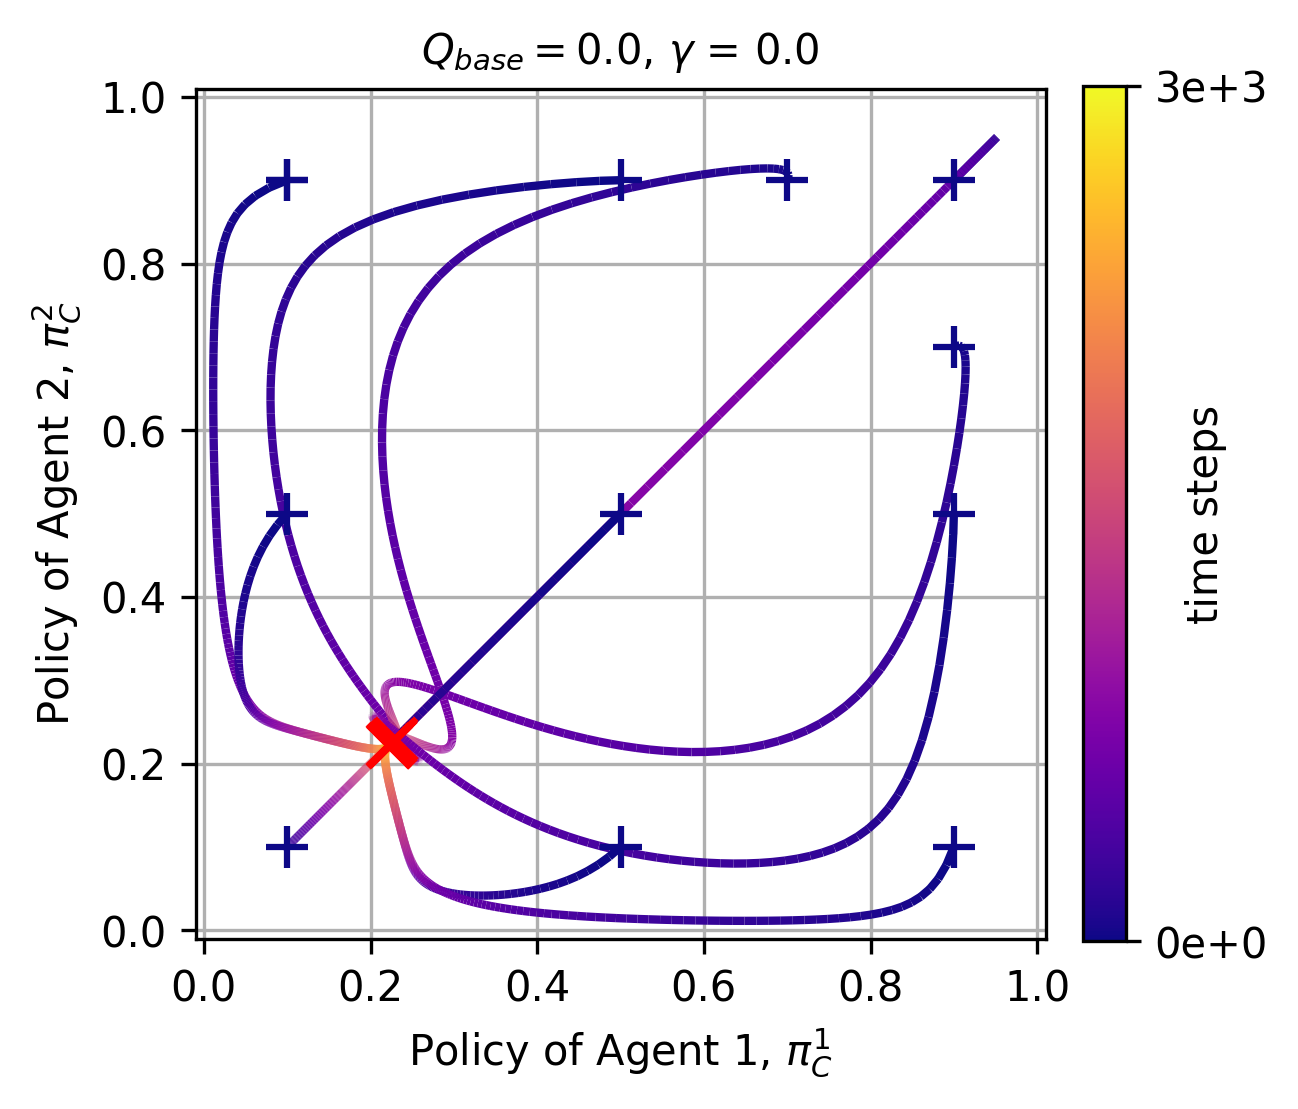

In [3]:
# enable inline plotting
%matplotlib inline

# Plotting settings
directory_for_figures = 'PaperFigures' # directory for saving the figures
if not os.path.exists(directory_for_figures):
    os.makedirs(directory_for_figures)
figsize = (4, 4)
dpi = 300

# Set the game parameters
reward_function = reward_matrix_for_two_player_PD
game_title_short = 'PD'
game_title = 'Prisoner\'s Dilemma'
first_action_title = 'Cooperation'
reward_matrices = get_individual_matrices(reward_function)

# Define learning parameters
learning_rate = 0.01
discount_factor = 0.
temperature = 1

# calculate the fixed point policy, the target Q-values and eigenvalues and eigenvectors
fixed_point_policy = calculate_fixed_point_policy(temperature, discount_factor, print_solution = False)
Q_target_C, Q_target_D = calculate_target_Q_values(fixed_point_policy, discount_factor)
eigenvalues, eigenvectors = calculate_eigenvalues_and_eigenvectors(discount_factor, temperature, learning_rate, print_solution = False)

# Define base value around which the Q-values are centered if given initial probabilities
base_value = 0 * 1/(1-discount_factor) #Q_target_C + (Q_target_D - Q_target_C)/2  
if discount_factor == 0:
    num_time_steps = int(3e3)
elif discount_factor == 0.8 and base_value == 0:
    num_time_steps = int(1e5)
elif discount_factor == 0.8:
    num_time_steps = int(1e5)

# or uncomment next line and set the number of time steps manually
# num_time_steps = int(3e3)

# generate initial probability pairs for the complete 1x1 square in policy space
if False: # use this for symmetric initial probability pairs
    x = np.array([0.9])
    initial_probability_pairs = [(x[i], x[j]) for i in range(len(x)) for j in range(len(x))]
else: # use this for specific initial probability pairs
    initial_probability_pairs = [(0.1, 0.9), (0.5, 0.9), (0.7,0.9), (0.9, 0.9), (0.9,0.7),
                        (0.1, 0.5), (0.5, 0.5), (0.9, 0.5),
                        (0.1, 0.1), (0.5, 0.1), (0.9, 0.1)]

# Plot the dynamics in policy space
fig = plt.figure(figsize=figsize, dpi=dpi)
plot_time_evolution = True
label_flag_added = False # Flag to add labels only once
marker_size = 100
color_start_scatter = plt.cm.plasma(0.0) # dark purple
color_end_scatter = 'red' #plt.cm.plasma(1.0) # bright yellow
for i, initial_probability_pair in enumerate(initial_probability_pairs):
    # generate the initial Q-values for the agents from the initial probabilities centered around the base value
    Q_values_initial_list = [generate_q_values(probability, temperature, base_value) for probability in initial_probability_pair]

    # define the agents
    agents = [DeterministicAgent(Q_values_initial, learning_rate, discount_factor, temperature) for Q_values_initial in Q_values_initial_list]
    
    # run deterministic Q-learning model
    for time_step in range(num_time_steps):
        deterministic_QL_step(agents, reward_matrices)
    print("Run finished for initial probability pair", initial_probability_pair, f"Progress: {i+1}/{len(initial_probability_pairs)}")

    # plot only every n-th time step to reduce the number of lines
    n = 10
    # get the histories of probabilities to cooperate for each agent 
    prob_coop_of_agent_1_list = [vector[0] for vector in agents[0].prob_vector_history[::n]]
    prob_coop_of_agent_2_list = [vector[0] for vector in agents[1].prob_vector_history[::n]]

    # combine for each time steps the probabilities of both agents so that we can plot in the 1x1 square of policy space
    prob_coop_list = np.array([prob_coop_of_agent_1_list, prob_coop_of_agent_2_list]).T

    if plot_time_evolution:
        # Create a list of lines to plot the time evolution of the trajectories with a color gradient
        lines = [ [prob_coop_list[i], prob_coop_list[i+1]] for i in range(len(prob_coop_list)-1)]
        # Create a LineCollection
        lc = LineCollection(lines, cmap='plasma', linewidths=2, alpha=1)
        # Set the colors of the lines
        lc.set_array(np.linspace(0, 1, len(prob_coop_list)))
        # Add the LineCollection to the plot
        plt.gca().add_collection(lc)

        # Add a colorbar for the time evolution ONLY ONCE
        if i == 0:
            cbar = plt.colorbar(lc, fraction=0.046, pad=0.04)
            cbar.set_label('time steps', labelpad=-20, y=0.5)
            # lc is normalized so we need to set the ticks manually
            tick_values = [0, 1]
            cbar.set_ticks(tick_values)  # Set the ticks to the desired positions
            # Format tick labels into scientific notation manually
            tick_labels = [0, num_time_steps]
            tick_labels_scientific_notation = ["{:.0e}".format(tick_label) for tick_label in tick_labels]
            # Define a custom formatter to remove the leading zero in the exponent
            def custom_formatter(x):
                return f'{x:.0e}'.replace('e+0', 'e+').replace('e-0', 'e-')
            tick_labels_scientific_notation_reduced = [custom_formatter(tick_label) for tick_label in tick_labels]
            cbar.set_ticklabels([tick_label for tick_label in tick_labels_scientific_notation_reduced])

    else:
        # plot dynamics in policy-space in the 1x1 square
        plt.plot(prob_coop_list[:, 0], prob_coop_list[:, 1], alpha = 1)

    # plot start and end points of the trajectories
    plt.scatter(prob_coop_list[0, 0], prob_coop_list[0, 1], marker='+', color=color_start_scatter, zorder=10, s=marker_size)
    plt.scatter(prob_coop_list[-1, 0], prob_coop_list[-1, 1], marker='x', color=color_end_scatter, zorder=10, s=marker_size)
    # add labels only once
    if not label_flag_added:
        plt.scatter(prob_coop_list[0, 0], prob_coop_list[0, 1], marker='+', color=color_start_scatter, label='Start', s=marker_size)
        plt.scatter(prob_coop_list[-1, 0], prob_coop_list[-1, 1], marker='x', color=color_end_scatter, label='End', s=marker_size)
        label_flag_added = True

# add cosmetics to the plot
fontsize = None
Figure_format_for_publication = True
if True:
    if plot_time_evolution:
        if Figure_format_for_publication:
            title = (r'$Q_{base} =$' + f'{base_value:.1f}, ' + f'$\\gamma$ = {discount_factor}')
            plt.title(title, wrap=True, horizontalalignment='center', fontsize=fontsize)
        else:
            title = (f'{game_title}. ' + r'$Q_{base} =$' + f'{base_value:.1f}, ' + f'$\\gamma$ = {discount_factor}')
            plt.title(title, wrap=True, horizontalalignment='center', fontsize=fontsize)
    else:
        caption = (f'$\\alpha$ = {learning_rate}, T = {temperature}, $\\gamma$ = {discount_factor}\n'
                    f'Q-values are initialised around {base_value:.2f}.'
                    f'\nTrajectories span {num_time_steps:.0e} time steps.\n'
                )
        plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=fontsize)
    # set axis labels
    plt.xlabel(f'Policy of Agent 1, $\pi^1_{first_action_title[0]}$', fontsize=fontsize)
    plt.ylabel(f'Policy of Agent 2, $\pi^2_{first_action_title[0]}$', fontsize=fontsize)
    # set ticks of label to fontsize
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    # fix x and y axis to unit square
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.grid()
    # Ensure the axes are symmetrically scaled
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')

# save figure
plt.savefig(os.path.join(directory_for_figures, f'Fig3_{game_title_short}_DeterministicDynamics_discount_{discount_factor}_Qbase_{base_value}_temp_{temperature}_learningRate_{learning_rate}_numTimeSteps_{num_time_steps}.jpg'), dpi=dpi, bbox_inches='tight')
plt.show()